In [2]:
import os
import pandas as pd
import numpy as np 
import pingouin as pg 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [3]:
def Get_participants(folder_dir) : 
    participants = os.listdir(folder_dir)
    participants = sorted([ x.split(sep=".")[0] for x in participants if x.endswith(".csv") and not x.startswith(".")])
    

    return participants

def Partis_Dict(folder_dir) : 

    participants = Get_participants( folder_dir )

    participants_dict = { x : None for x  in participants} 
    
    for parti in participants_dict:
        arr = np.loadtxt( folder_dir + "/" + parti + ".csv", delimiter=",", dtype=float)
        
        participants_dict[parti] = arr
    
    return participants_dict

def Get_Blink(arr, threshold = 15): # 15번 이상 반복되는 것을 기준으로 설정

    blink  = np.zeros(arr.shape[1])

    for j in range(arr.shape[1]):  # 행방향 Row 순회

        state = 1
        repeat_count = 0

        for i in range(arr.shape[0]):  # 열방향 Col 순회
            
            if arr[i,j] == 0 and state == 1 : 
                state = 0
                repeat_count += 1 
            
            elif arr[i,j] == 0 and state == 0:
                repeat_count += 1

                if repeat_count >= threshold :
                    repeat_count = 0 
                    state = 2

            elif arr[i,j] != 0 and state == 2 : 
                blink[j] += 1 
                state = 1

            else: 
                repeat_count = 0

    return blink

def hard_Get_Blink(arr, threshold_closing = 10, threshold_opening= 5): # 기본 15번 이상 반복되는 것을 기준으로 설정 == 약 0.15초))

    blink  = np.zeros(arr.shape[1])

    for j in range(arr.shape[1]):  # 행방향 row 순회

        state = 1 # 눈 상태
        closing_repeat_count = 0
        opening_repeat_count = 0 

        for i in range(arr.shape[0]):  # 열방향 col 순회
            
            if arr[i,j] == 0 and state == 1 : 
                state = 0
                closing_repeat_count += 1 
            
            elif arr[i,j] == 0 and state == 0:
                closing_repeat_count += 1

                if closing_repeat_count >= threshold_closing :
                    closing_repeat_count = 0 
                    state = 2

            elif arr[i,j] != 0 and state == 2 : 
                opening_repeat_count += 1

                if opening_repeat_count >= threshold_opening :
                    closing_repeat_count = 0 
                    opening_repeat_count = 0
                    state = 1
                    blink[j] += 1 

            else: 
                closing_repeat_count = 0

    return blink

In [4]:
curr_dir = os.getcwd() + "/Eye_track"
right_dir = curr_dir + "/RightEyeStatus"
left_dir = curr_dir + "/LeftEyeStatus"

right_eyes = Partis_Dict(right_dir)
left_eyes = Partis_Dict(left_dir)

eyes = { parti : np.array([right_eyes[parti], left_eyes[parti]]).sum(axis=0) for parti in right_eyes.keys() }

print(len(eyes)) # 참가자수 
print(eyes[next(iter(eyes))].shape) # 참가자당 1명당 (frame_num == 11950 , video_num == 16 )

print("\n첫번째 참가자 BEFORE Embedding")
print("-"*50)
print(eyes[next(iter(eyes.keys()))])

52
(11950, 16)

첫번째 참가자 BEFORE Embedding
--------------------------------------------------
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


In [5]:
# 데이터 인코딩
for participant in eyes :
    eye = np.where(eyes[participant] >= 2, 1, 0) # 2 == 양쪽다 뜬 경우, 1 == 한쪽이 측정이 안된 경우, 0 == 눈을 감은 경우
    eyes[participant] = eye

print("첫번째 참가자 After")
print("-"*50)
print(eyes[next(iter(eyes.keys()))])

첫번째 참가자 After
--------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [6]:
# 전체 영상 별 평균 Blinking 횟수
avg_blink_arr = []

for participant in eyes : 
    blink = hard_Get_Blink(eyes[participant], threshold_closing=10, threshold_opening=5)
    avg_blink_arr.append(blink)

avg_blink_arr = np.array(avg_blink_arr)

# for index, participant in enumerate(eyes.keys()) : 
#     print(participant, avg_blink_arr[index])

In [7]:
data = avg_blink_arr.reshape(-1,4,4).mean(axis=2).flatten()
blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(avg_blink_arr)
names = np.repeat(np.arange(len(avg_blink_arr)),4)

df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)
print(results)


post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')
print("-"*100,'\n')
print(post_hoc[['A','B','T','p-unc']].round(3))
print("="*100,'\n') 

   Source  ddof1  ddof2        F     p-unc  p-GG-corr       ng2       eps  \
0  blocks      3    153  5.76802  0.000918   0.001183  0.016215  0.944339   

   sphericity   W-spher   p-spher  
0        True  0.904097  0.414381  
---------------------------------------------------------------------------------------------------- 

      A     B      T  p-unc
0  HMHB  HMLB -1.351  0.183
1  HMHB  LMHB -4.531  0.000
2  HMHB  LMLB -1.973  0.054
3  HMLB  LMHB -3.027  0.004
4  HMLB  LMLB -0.608  0.546
5  LMHB  LMLB  2.042  0.046



In [8]:
HM = [0,1,2,3,4,5,6,7]
LM = [8,9,10,11,12,13,14,15]
HB = [0,1,2,3,8,9,10,11]
LB = [4,5,6,7,12,13,14,15]

print("[Motion]")
print(pg.ttest(avg_blink_arr.mean(axis=0)[LM].flatten(), avg_blink_arr.mean(axis=0)[HM].flatten(), paired= True, alternative='greater').iloc[:,:4])
print("-"*50)
print("\n")
print("[Brightness]")
print(pg.ttest(avg_blink_arr.mean(axis=0)[LB].flatten(), avg_blink_arr.mean(axis=0)[HB].flatten(), paired= True, alternative='less' ).iloc[:,:4])
print("-"*50)

[Motion]
               T  dof alternative     p-val
T-test  2.756022    7     greater  0.014129
--------------------------------------------------


[Brightness]
               T  dof alternative    p-val
T-test -0.325716    7        less  0.37708
--------------------------------------------------


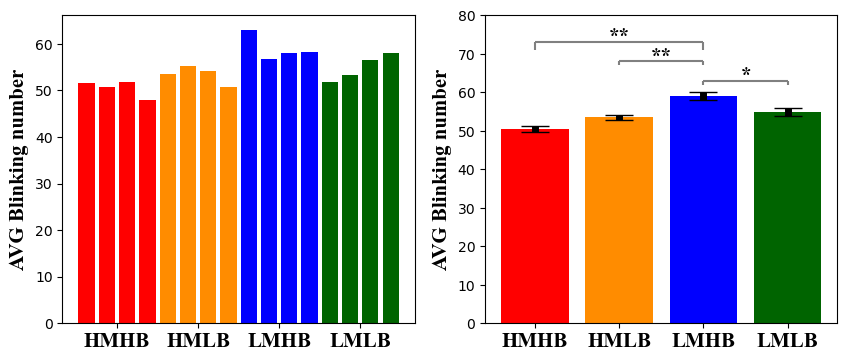

In [9]:
avg_blink = np.round(avg_blink_arr.mean(axis=0), 2)
se_blink = [ np.std(avg_blink[x:x+4]) / np.sqrt(5) for x in range(0,16,4)]


fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,4)

def singnificantLine(ax, x1, x2, y, text, font_size = 15, ha_ = 'center',family_ = 'Times New Roman', weight_ ='bold' ):
    ax.hlines(y, x1, x2, colors='gray', linestyles='solid')
    ax.vlines(x1, y, y-(x2-x1), colors='gray', linestyles='solid')
    ax.vlines(x2, y, y-(x2-x1), colors='gray', linestyles='solid')
    ax.text( (x1+x2)/2, y, text, fontsize = font_size, ha = ha_,family = family_, weight=weight_)

font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 15,
      'va' : 'center',
      'ha' : 'center' }

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']

axs[0].bar(range(16), avg_blink, color = np.repeat(colors, 4) )
axs[0].set_xticks( [ 1.5, 5.5, 9.5, 13.5], block_names, fontsize = 15, family = "Times New Roman", weight='bold'); 
axs[0].set_ylabel("AVG Blinking number", fontsize = 15,family = "Times New Roman", weight='bold' );

axs[1].bar(range(4), avg_blink.reshape(-1,4).mean(axis=1), color = colors )
axs[1].set_xticks(range(4), block_names , fontsize = 15, family = "Times New Roman", weight='bold');
axs[1].set_ylabel("AVG Blinking number", fontsize = 15,family = "Times New Roman", weight='bold' );
axs[1].set_ylim(0,80)
axs[1].errorbar(range(4), avg_blink.reshape(-1,4).mean(axis=1) ,yerr = se_blink, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black');
singnificantLine(axs[1], 0, 2, 73, '**')
singnificantLine(axs[1], 1, 2, 68, '**')
singnificantLine(axs[1], 2, 3, 63, '*')


# y = avg_blink.reshape(-1,4).mean(axis=1) + 3
# for i, blc in enumerate( avg_blink.reshape(-1,4).mean(axis=1).round(2) ): 
#     plt.text(x = i, y= y[i], s= round(blc, 3), fontdict=font_dict, color='black')

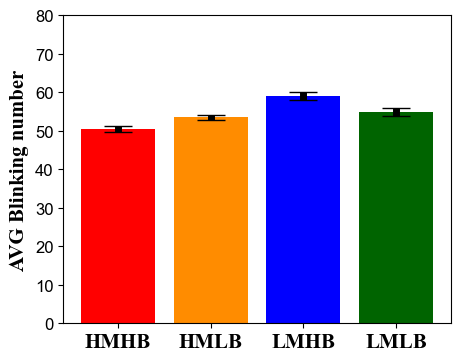

In [10]:
fig = plt.figure(figsize=(5,4))

plt.bar(range(4), avg_blink.reshape(-1,4).mean(axis=1), color = colors )
plt.xticks(range(4), block_names , fontsize = 15, family = "Times New Roman", weight='bold');
plt.ylabel("AVG Blinking number", fontsize = 15,family = "Times New Roman", weight='bold' );
plt.ylim(0,80)
plt.yticks( family = 'Arial', fontsize= 12)
plt.errorbar(range(4), avg_blink.reshape(-1,4).mean(axis=1) ,yerr = se_blink, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black');
# singnificantLine(plt, 0, 2, 73, '**')
# singnificantLine(plt, 1, 2, 68, '**')
# singnificantLine(plt, 2, 3, 63, '*')
#plt.text(-0.3, 72.5,'(a)', ha ='center', fontsize = 20, family = 'Arial', weight='bold' )

In [11]:
# Window 내에서 평균 Blinking 횟수

sampling_rate = 100
video_len = 120 
window_size = 1

window_blink_arr = []

for participant in eyes : 
    
    data = eyes[participant]
    participant_arr = []
    
    for index in range(video_len - window_size +1) :
        
        if index*sampling_rate + window_size*sampling_rate <= len(data) : 
            arr = data[index*sampling_rate : index*sampling_rate + window_size*sampling_rate]
            # participant_arr.append(Get_Blink(arr, threshold=10))
            participant_arr.append(hard_Get_Blink(arr))
        else :
            arr = data[index*sampling_rate : len(data)]
            participant_arr.append(hard_Get_Blink(arr))

    window_blink_arr.append(participant_arr)

window_blink_arr = np.array(window_blink_arr)
    
print(window_blink_arr.shape) # ( 참가자수, Window 개수, 영상개수 )

(52, 120, 16)


In [15]:
save_dir = os.getcwd() + "/Window_data/Blink"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for ind, participant in enumerate(window_blink_arr) :
    np.savetxt(save_dir + f"/{ind}.csv", participant, delimiter = ",")

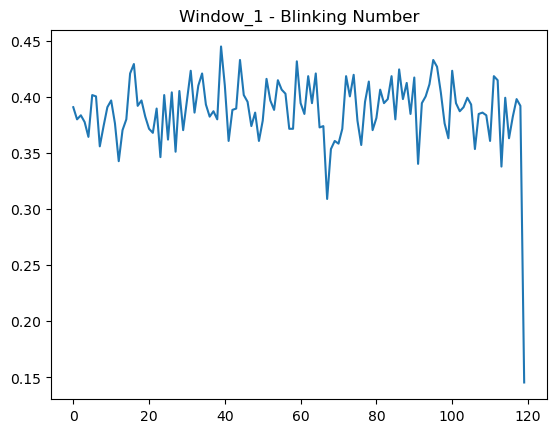

In [ ]:
fig = plt.figure()

plt.plot(range(window_blink_arr.shape[1]), window_blink_arr.mean((0,2)))
#plt.xlim(0,)
plt.title("Window_{0} - Blinking Number".format(window_size));

(4, 120)


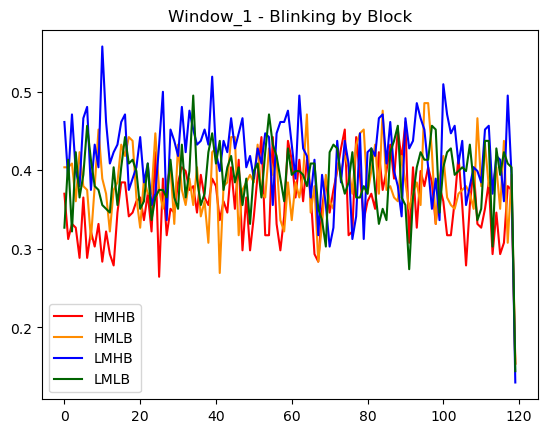

In [ ]:
block_data = np.array( [window_blink_arr.mean(axis=0)[:, x:x+4].mean(axis=1) for x in range(0,16,4) ] ) 
print(block_data.shape)

fig = plt.figure()

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']

for block in range(len(block_data)) :
    plt.plot(range(window_blink_arr.shape[1]), block_data[block], color = colors[block])

plt.legend(block_names)
plt.title("Window_{0} - Blinking by Block".format(window_size));

(2, 120)


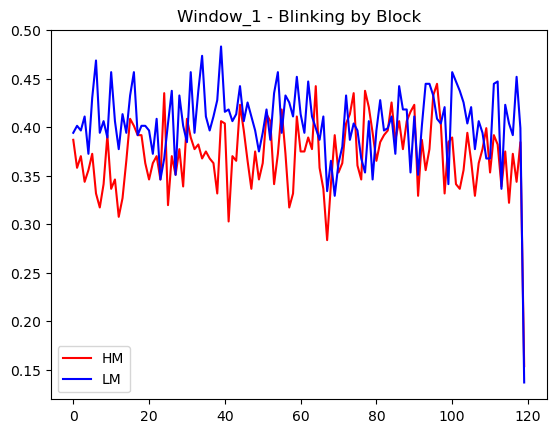

In [ ]:
block_data = np.array( [window_blink_arr.mean(axis=0)[:, x:x+8].mean(axis=1) for x in range(0,16,8) ]  )
print(block_data.shape)
fig = plt.figure()

colors = ['r','b']
block_names = ["HM", 'LM']

for block in range(len(block_data)) :
    plt.plot(range(window_blink_arr.shape[1]), block_data[block], color = colors[block])
plt.legend(block_names)
plt.title("Window_{0} - Blinking by Block".format(window_size));

In [ ]:
AVG_dir = os.getcwd() + "/AVG"

if not os.path.isdir(AVG_dir):
    os.mkdir(AVG_dir)

df = pd.DataFrame(avg_blink_arr)
df.to_csv(AVG_dir + "/Blinking.csv")

IndexError: index 52 is out of bounds for axis 0 with size 52

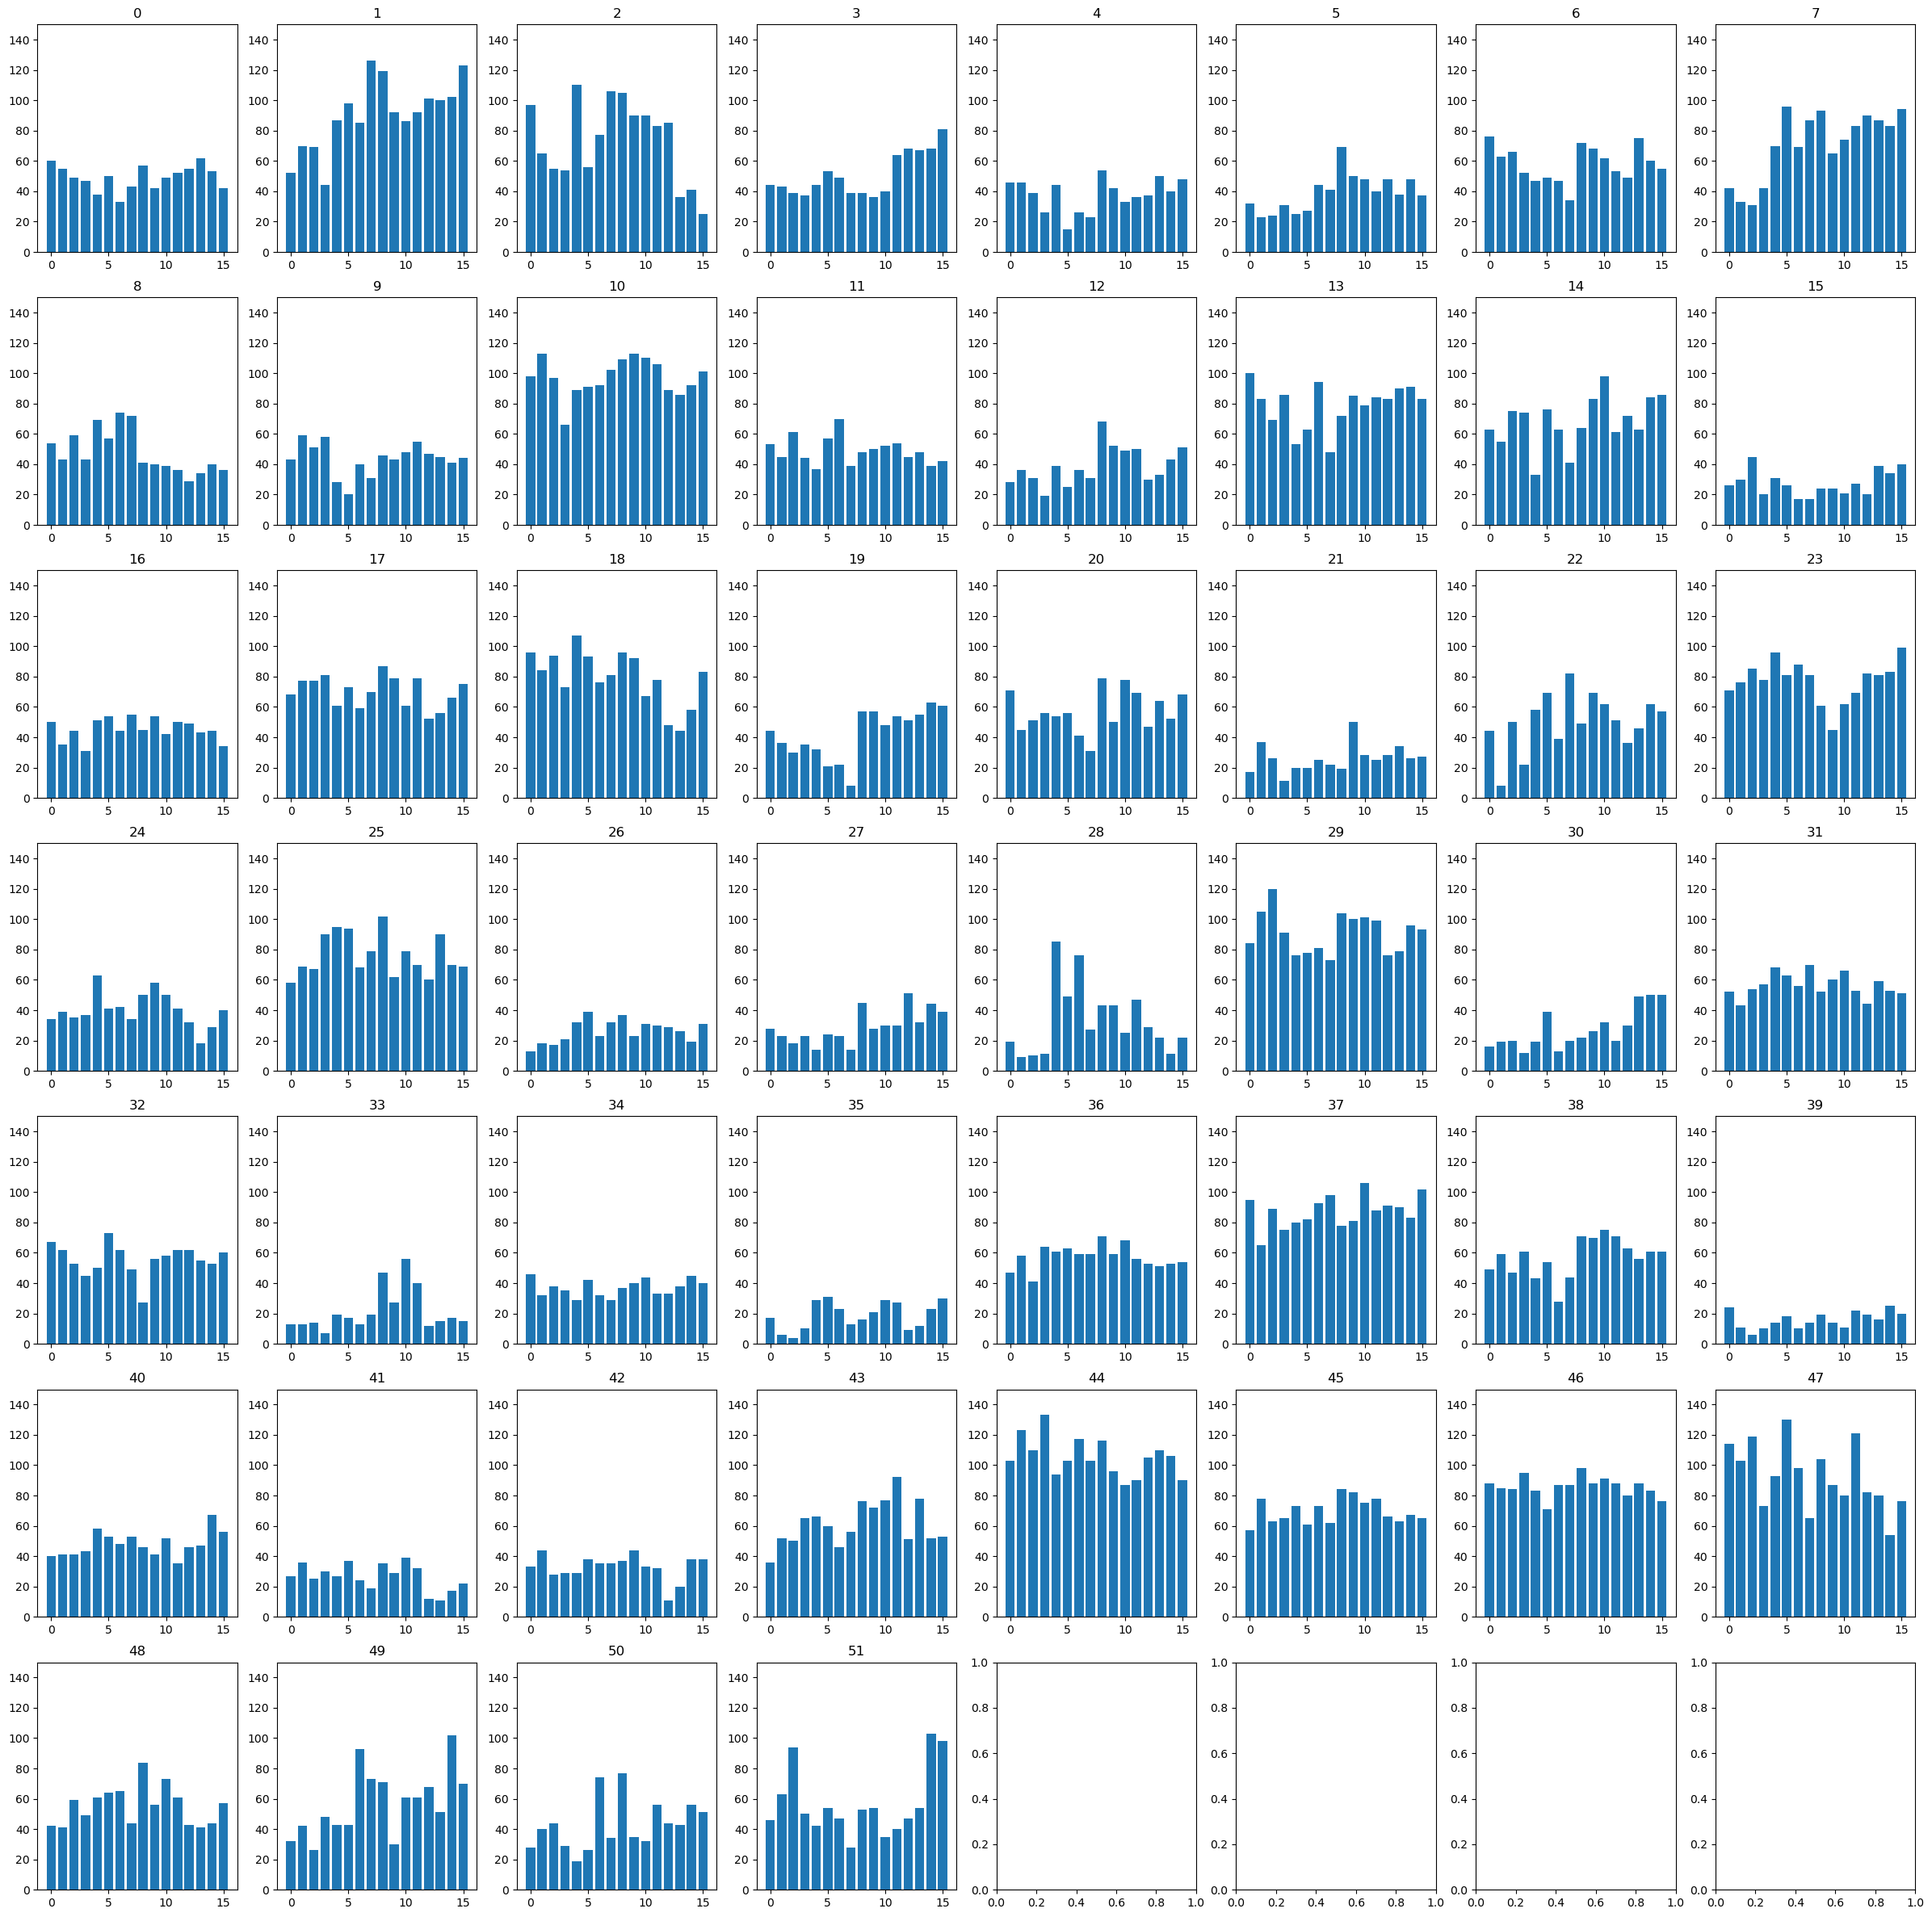

In [ ]:
avg_blink_arr.round(2)

fig, axs = plt.subplots(7,8)
axs = axs.flatten()
fig.set_size_inches(30,30);

for ind, ax in enumerate(axs) :
    ax.bar(range(16), avg_blink_arr[ind]);
    ax.set_ylim(0,150);
    ax.set_title(ind);

fig.tight_layout();